<a href="https://colab.research.google.com/github/yaniv256/VAEs-in-Economics/blob/master/Notebooks/vae_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.keras as keras
keras.__version__

'2.2.4-tf'

In [0]:
from tensorflow.keras import backend as K
K.clear_session()

# One Dimesional Variational Auto-Encoders

This notebook contains code for the One Dimensional VAE Workshop by Yaniv Ben-Ami. The code was developed from an example found in Chapter 8, Section 4 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) by François Chollet and the reader is invited to check that out for details.


![VAE](https://s3.amazonaws.com/book.keras.io/img/ch8/vae.png)
Source: Deep Learning with Python 

In [0]:
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd

In [0]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [5]:
labels = ['CRIM - per capita crime rate by town', 
          'ZN - proportion of residential land zoned for lots over 25,000 sq.ft.',
          'INDUS - proportion of non-retail business acres per town',
          'CHAS - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)',
          'NOX - nitric oxides concentration (parts per 10 million)',
          'RM - average number of rooms per dwelling',
          'AGE - proportion of owner-occupied units built prior to 1940',
          'DIS - weighted distances to five Boston employment centres',
          'RAD - index of accessibility to radial highways',
          'TAX - full-value property-tax rate per $10,000',
          'PTRATIO - pupil-teacher ratio by town',
          'B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town',
          'LSTAT - % lower status of the population',
          'MEDV - Median value of owner-occupied homes in $1000\'s']

train_data = np.concatenate([train_data, train_targets.reshape((len(train_targets),1))], axis = 1)
test_data = np.concatenate([test_data, test_targets.reshape((len(test_targets),1))], axis = 1)
data = np.concatenate([train_data,test_data],axis=0)
data = pd.DataFrame(data, columns = labels)
data

,CRIM - per capita crime rate by town,"ZN - proportion of residential land zoned for lots over 25,000 sq.ft.",INDUS - proportion of non-retail business acres per town,CHAS - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise),NOX - nitric oxides concentration (parts per 10 million),RM - average number of rooms per dwelling,AGE - proportion of owner-occupied units built prior to 1940,DIS - weighted distances to five Boston employment centres,RAD - index of accessibility to radial highways,"TAX - full-value property-tax rate per $10,000",PTRATIO - pupil-teacher ratio by town,B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town,LSTAT - % lower status of the population,MEDV - Median value of owner-occupied homes in $1000's
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,3.47428,0.0,18.10,1.0,0.718,8.780,82.9,1.9047,24.0,666.0,20.2,354.55,5.29,21.9
502,0.07896,0.0,12.83,0.0,0.437,6.273,6.0,4.2515,5.0,398.0,18.7,394.92,6.78,24.1
503,1.83377,0.0,19.58,1.0,0.605,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92,50.0
504,0.35809,0.0,6.20,1.0,0.507,6.951,88.5,2.8617,8.0,307.0,17.4,391.70,9.71,26.7


In [6]:
from sklearn.preprocessing import QuantileTransformer

qt_trans = QuantileTransformer(n_quantiles=101, random_state=2)
qt_trans.fit(train_data)
qt = pd.DataFrame(qt_trans.transform(data))
qt.columns = labels
qt

,CRIM - per capita crime rate by town,"ZN - proportion of residential land zoned for lots over 25,000 sq.ft.",INDUS - proportion of non-retail business acres per town,CHAS - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise),NOX - nitric oxides concentration (parts per 10 million),RM - average number of rooms per dwelling,AGE - proportion of owner-occupied units built prior to 1940,DIS - weighted distances to five Boston employment centres,RAD - index of accessibility to radial highways,"TAX - full-value property-tax rate per $10,000",PTRATIO - pupil-teacher ratio by town,B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town,LSTAT - % lower status of the population,MEDV - Median value of owner-occupied homes in $1000's
0,0.676317,0.000,0.450000,0.0,0.510000,0.459433,0.693174,0.618406,0.280,0.425000,0.93,1.000000,0.829206,0.201216
1,0.038147,0.975,0.044131,0.0,0.078834,0.954588,0.031916,0.860000,0.070,0.526449,0.07,0.694930,0.028496,0.944661
2,0.790980,0.000,0.760000,0.0,0.750000,0.029960,1.000000,0.022964,1.000,0.865000,0.74,0.260637,0.036753,1.000000
3,0.107189,0.000,0.260000,0.0,0.430000,0.389518,0.164760,0.831271,0.505,0.075000,0.74,1.000000,0.318078,0.515000
4,0.751558,0.000,0.760000,0.0,0.890000,0.609602,0.630542,0.394235,1.000,0.865000,0.74,0.507947,0.649349,0.296667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.747431,0.000,0.760000,1.0,0.920000,1.000000,0.545660,0.195013,1.000,0.865000,0.74,0.181114,0.146124,0.557463
502,0.240501,0.000,0.600000,0.0,0.160000,0.546759,0.006284,0.659450,0.505,0.595000,0.47,0.668167,0.243929,0.713165
503,0.703974,0.000,0.915000,1.0,0.680000,0.963925,0.884274,0.237754,0.505,0.645000,0.07,0.442515,0.001650,1.000000
504,0.544350,0.000,0.330000,1.0,0.395000,0.856692,0.633005,0.456301,0.720,0.425000,0.27,0.514339,0.410963,0.783268


In [7]:
x_train = qt[:len(train_data)]
x_test = qt[len(train_data):]
x_train.shape, x_test.shape

((404, 14), (102, 14))

In [8]:
input_shape = (x_train.shape[1],)
latent_dim = 1  # Dimensionality of the latent space: a line
dense_width = 1024

input_x = keras.Input(shape=input_shape)

x = layers.Dense(dense_width, activation='relu')(input_x)
x = layers.Dense(dense_width, activation='relu')(x)
x = layers.Dense(dense_width, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [0]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(dense_width,activation='relu')(decoder_input)
x = layers.Dense(dense_width,activation='relu')(x)
x = layers.Dense(dense_width,activation='relu')(x)

x = layers.Dense(input_shape[0])(x)

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

In [0]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        xent_loss = keras.metrics.mse(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_x, z_decoded])

In [12]:
vae = Model(input_x, y)
vae.compile(optimizer=optimizers.Adam(0.001), loss=None)

n_batch_sizes=5

history =['']*n_batch_sizes

# Train the VAE on boston housing data

for i in range(n_batch_sizes):

  # Alternate between a few epochs with large batch size (reliable decrease in 
  # loss but weak and overfitting) and lots of epochs with small batch size
  # (strong and non-overfitting but could increase loss)
  batch_size = 512*(1-(i%2)) + 16*(i%2)
  epochs = 20*(1-(i%2)) + 100*(i%2)

  print('Batch size:', batch_size)

  history[i] = vae.fit(x=x_train, y=None,
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(x_test, None))


Batch size: 512
Train on 404 samples, validate on 102 samples
Epoch 1/20
404/404 [==============================] - 1s 3ms/sample - loss: 0.3153 - val_loss: 0.2565
Epoch 2/20
404/404 [==============================] - 0s 19us/sample - loss: 0.2562 - val_loss: 0.1640
Epoch 3/20
404/404 [==============================] - 0s 18us/sample - loss: 0.1607 - val_loss: 0.3415
Epoch 4/20
404/404 [==============================] - 0s 17us/sample - loss: 0.2807 - val_loss: 0.1121
Epoch 5/20
404/404 [==============================] - 0s 17us/sample - loss: 0.1191 - val_loss: 0.1212
Epoch 6/20
404/404 [==============================] - 0s 17us/sample - loss: 0.1221 - val_loss: 0.1282
Epoch 7/20
404/404 [==============================] - 0s 17us/sample - loss: 0.1273 - val_loss: 0.1158
Epoch 8/20
404/404 [==============================] - 0s 18us/sample - loss: 0.1105 - val_loss: 0.0870
Epoch 9/20
404/404 [==============================] - 0s 18us/sample - loss: 0.0867 - val_loss: 0.1071
Epoch 10/20


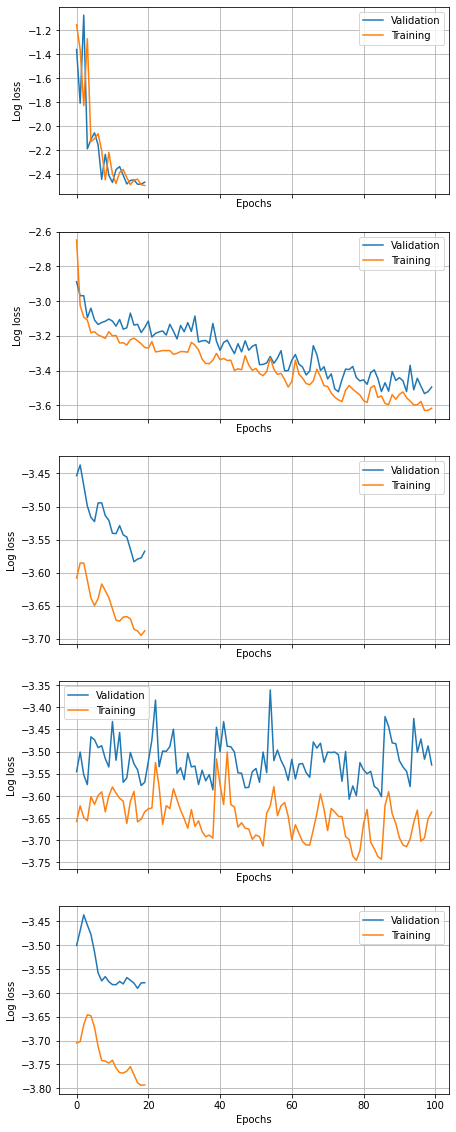

In [13]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(len(history), 1, figsize=(7, len(history)*4), sharex=True)

for i in range(len(history)):

  ax[i].plot(history[i].epoch, np.log(history[i].history['val_loss']), label='Validation')
  ax[i].plot(history[i].epoch, np.log(history[i].history['loss']), label='Training')
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel('Log loss')
  ax[i].legend()
  ax[i].grid()


In [14]:
encoder = Model(input_x,z_mean)
encoded_data=encoder.predict(qt).flatten()

encoded_data.shape

(506,)

In [15]:
grid_x = np.linspace(-2,2,401)
decoded=decoder.predict(grid_x)
decoded.shape

(401, 14)

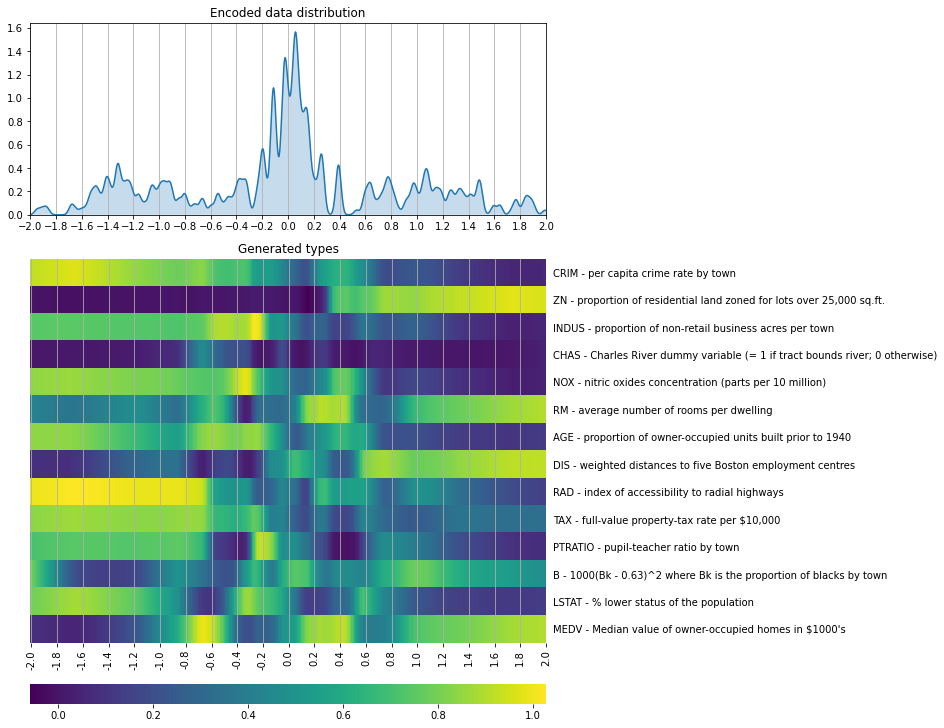

In [16]:
import seaborn as sns

fig = plt.figure(figsize=(13,10),constrained_layout=True)
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1:,:])

ax1.set_title('Encoded data distribution')
sns.kdeplot(encoded_data,bw=0.02, shade = True, ax=ax1, gridsize=2000)
ax1.set_xticks( np.linspace(-2,2,21))
ax1.set_xlim(-2,2)
ax1.grid(axis='x')

ax2.set_title('Generated types')

sns.heatmap(decoded.T,cmap='viridis',ax=ax2, cbar_kws={'orientation':'horizontal'})
ax2.set_xticks(np.linspace(1,len(grid_x),21))
ax2.set_xticklabels(['{:.2}'.format(a) for a in np.linspace(-2,2,21)])
ax2.set_yticklabels(labels)
ax2.tick_params(axis='y',labelright=True, labelleft=False, 
                left=False, labelrotation=0)
ax2.grid(axis='x')
